# Comparativo de Precipitação - ONS vs TOK

Este notebook compara dados de precipitação de duas fontes (ONS e TOK) por pontos de interesse.

## Parâmetros Configuráveis:
- **nome_modelo**: Nome do modelo a ser analisado
- **horizonte**: Horizonte de previsão do modelo
- **data_rodada**: Data da rodada do modelo (formato: YYYYMMDD)
- **diretorio_base**: Diretório base onde os dados estão armazenados

## Saídas:
- Tabelas com heatmap de diferenças
- Acumulado de diferenças positivas e negativas
- Desvio padrão das diferenças

In [34]:
# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from tok_gcp_tools.storage import GoogleStorage
from datetime import datetime, timedelta
import zipfile
import tarfile

#warnings.filterwarnings('ignore')

webhook = GoogleStorage('tok_webhook')
storage_tok = GoogleStorage('storage.tempook.com')

# Configurações de visualização
plt.style.use('default')
sns.set_palette('husl')
%matplotlib inline

## 1. Configuração dos Parâmetros

Defina os parâmetros do modelo e caminhos de entrada/saída.

In [ ]:
# ============================================
# PARÂMETROS CONFIGURÁVEIS
# ============================================

# Nome do modelo
nome_modelo = "GEFS"

nome_modelo_tok = {
    "ECMWF": "ECENS",
    "GEFS": "GEFS",
    # Adicione outros modelos conforme necessário
}

# Horizonte de previsão (em dias ou horas, dependendo do modelo)
horizonte = 15

# Data da rodada (formato: YYYYMMDD)
data_rodada = "20260122"

# Diretório base onde os dados estão armazenados
diretorio_base = nome_modelo  # Use "dados_exemplo" para dados de teste ou especifique seu caminho

# ============================================
# CONSTRUÇÃO DOS CAMINHOS
# ============================================

# Caminho de entrada (varia de acordo com nome do modelo e data da rodada)
caminho_input = Path(diretorio_base) / data_rodada

# Caminhos específicos para ONS e TOK
caminho_ons = caminho_input / "ONS"
caminho_ons.mkdir(parents=True, exist_ok=True)
caminho_tok = caminho_input / "TOK"
caminho_tok.mkdir(parents=True, exist_ok=True)

# Caminho de saída (organizado como o input)
caminho_output = caminho_input / "Output"
caminho_output.mkdir(parents=True, exist_ok=True)

print(f"Modelo: {nome_modelo}")
print(f"Horizonte: {horizonte}")
print(f"Data da rodada: {data_rodada}")
print(f"\nCaminhos:")
print(f"  Input: {caminho_input}")
print(f"  ONS: {caminho_ons}")
print(f"  TOK: {caminho_tok}")
print(f"  Output: {caminho_output}")

Modelo: ECMWF
Horizonte: 15
Data da rodada: 20260122

Caminhos:
  Input: ECMWF/20260122
  ONS: ECMWF/20260122/ONS
  TOK: ECMWF/20260122/TOK
  Output: ECMWF/20260122/Output



### 1.1. Baixar os dados
Download dos dados de chuva e tranformação para o código adiante.

In [36]:
# ============================================
# DOWNLOAD DOS DADOS DO ONS (tok_webhook)
# ============================================

chuva_ons_filename = f"modelo_{nome_modelo.lower()}_{data_rodada}.zip"
caminho_chuva_ons_zip = f"produtos_ons/modelo_{nome_modelo.lower()}/{chuva_ons_filename}"
print(caminho_chuva_ons_zip)
webhook.download_file(str(caminho_chuva_ons_zip), str(caminho_ons / chuva_ons_filename))
# UNZIP DOS DADOS DO ONS
with zipfile.ZipFile(caminho_ons / chuva_ons_filename, 'r') as zip_ref:
    zip_ref.extractall(caminho_ons)
# REMOVER O ARQUIVO ZIP APÓS EXTRAIR
(caminho_ons / chuva_ons_filename).unlink()
# MONTAGEM DO ARQUIVO CSV DO ONS
    # LER O ARQUIVO ECMWF_m .dat E COLOCAR AS DATAS E DEPOIS STACK
    # SALVAR O ARQUIVO CSV
ons_data = pd.read_csv(caminho_ons / f"{nome_modelo}_m_{datetime.strptime(data_rodada,'%Y%m%d'):%d%m%y}.dat", header=None, sep='\\s+')
ons_data.columns = ['psat', 'lat', 'lon'] + [f'{datetime.strptime(data_rodada, "%Y%m%d") + timedelta(1+i):%Y-%m-%d}' for i in range(len(ons_data.columns)-3)]
ons_data.drop(columns=['lat', 'lon'], inplace=True)
ons_data = pd.melt(ons_data, id_vars=['psat'], var_name='data', value_name='precipitacao_mm')
ons_data.columns = ['ponto', 'data', 'precipitacao_mm']
ons_data.to_csv(caminho_ons / f"precipitacao_ons.csv", index=False)
# ============================================
# DOWNLOAD DOS DADOS DO ONS (tok_webhook)
# ============================================
chuva_tok_filename = f"PMEDIA_{nome_modelo_tok.get(nome_modelo)}av_precip_{data_rodada}.tar.gz"
caminho_chuva_tok_tar = f"Comercializadora/Arquivos/PMEDIA/{nome_modelo_tok.get(nome_modelo)}_estat/\
{nome_modelo_tok.get(nome_modelo)}av_precip/{datetime.strptime(data_rodada, '%Y%m%d'):%Y-%m}/{chuva_tok_filename}"
print(caminho_chuva_tok_tar)
storage_tok.download_file(str(caminho_chuva_tok_tar), str(caminho_tok / chuva_tok_filename))
# UNZIP DOS DADOS DO TOK
with tarfile.open(caminho_tok / chuva_tok_filename, 'r:gz') as tar_ref:
    tar_ref.extractall(caminho_tok)
# REMOVER O ARQUIVO TAR.GZ APÓS EXTRAIR
(caminho_tok / chuva_tok_filename).unlink()
# LER A LISTA DE ARQUIVOS EXTRAÍDOS
# JUNTAR TODOS OS ARQUIVOS CSV EM UM ÚNICO DATAFRAME
# FAZER MERGE COM O ARQUIVO base_de_estacoes.csv com lat/lon dos pontos

tok_files = list(caminho_tok.glob("*.dat"))
tok_data = pd.concat([pd.read_csv(f, sep='\\s+', names=['lon', 'lat', f'{datetime.strptime(str(f).split('.')[0][-6:], "%d%m%y"):%Y-%m-%d}'], index_col=[1,0]) for f in tok_files], axis=1).reset_index()
base_estacoes = pd.read_csv("base_de_estacoes.csv", sep=",")
tok_data = pd.merge(base_estacoes, tok_data, on=['lat', 'lon'], how="right").reset_index()
tok_data = pd.melt(tok_data.drop(columns=['index', 'lat', 'lon']), id_vars=['ponto'], var_name='data', value_name='precipitacao_mm')
tok_data.to_csv(caminho_tok / f"precipitacao_tok.csv", index=False)

01/23/2026 05:33:17 PM - 530103884204 - tok_gcp_tools.storage.py [line 65] - INFO: Conectado no bucket tok_webhook!
01/23/2026 05:33:17 PM - 530103884204 - tok_gcp_tools.storage.py [line 76] - INFO: Arquivo não localizado no caminho: ECMWF/20260122/ONS/modelo_ecmwf_20260122.zip. O download será iniciado


produtos_ons/modelo_ecmwf/modelo_ecmwf_20260122.zip


01/23/2026 05:33:17 PM - 530103884204 - tok_gcp_tools.storage.py [line 79] - INFO: Arquivo foi baixado no caminho: ECMWF/20260122/ONS/modelo_ecmwf_20260122.zip!
01/23/2026 05:33:18 PM - 530103884204 - tok_gcp_tools.storage.py [line 65] - INFO: Conectado no bucket storage.tempook.com!
01/23/2026 05:33:18 PM - 530103884204 - tok_gcp_tools.storage.py [line 76] - INFO: Arquivo não localizado no caminho: ECMWF/20260122/TOK/PMEDIA_ECENSav_precip_20260122.tar.gz. O download será iniciado
01/23/2026 05:33:18 PM - 530103884204 - tok_gcp_tools.storage.py [line 79] - INFO: Arquivo foi baixado no caminho: ECMWF/20260122/TOK/PMEDIA_ECENSav_precip_20260122.tar.gz!


Comercializadora/Arquivos/PMEDIA/ECENS_estat/ECENSav_precip/2026-01/PMEDIA_ECENSav_precip_20260122.tar.gz


/tmp/ipykernel_32017/2494268905.py:33: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar_ref.extractall(caminho_tok)


## 2. Função para Carregar Dados

Funções auxiliares para carregar dados de diferentes fontes.

In [37]:
def carregar_dados_fonte(caminho, fonte):
    """
    Carrega dados de precipitação de uma fonte específica.
    
    Parâmetros:
    -----------
    caminho : Path
        Caminho para o diretório com os dados
    fonte : str
        Nome da fonte (ONS ou TOK)
    
    Retorna:
    --------
    DataFrame com os dados de precipitação
    """
    # Procura por arquivos CSV, Excel ou Parquet no diretório
    arquivos_csv = list(caminho.glob("*.csv"))
    arquivos_excel = list(caminho.glob("*.xlsx")) + list(caminho.glob("*.xls"))
    arquivos_parquet = list(caminho.glob("*.parquet"))
    
    if arquivos_csv:
        print(f"Carregando dados {fonte} de: {arquivos_csv[0].name}")
        return pd.read_csv(arquivos_csv[0])
    elif arquivos_excel:
        print(f"Carregando dados {fonte} de: {arquivos_excel[0].name}")
        return pd.read_excel(arquivos_excel[0])
    elif arquivos_parquet:
        print(f"Carregando dados {fonte} de: {arquivos_parquet[0].name}")
        return pd.read_parquet(arquivos_parquet[0])
    else:
        print(f"AVISO: Nenhum arquivo de dados encontrado em {caminho}")
        # Retorna dados de exemplo para demonstração
        return gerar_dados_exemplo(fonte)

def gerar_dados_exemplo(fonte):
    """
    Gera dados de exemplo para demonstração quando os arquivos não existem.
    """
    np.random.seed(42 if fonte == "ONS" else 43)
    
    # Cria dados de exemplo com pontos de interesse e séries temporais
    pontos = [f"Ponto_{i:02d}" for i in range(1, 11)]
    datas = pd.date_range(start='2026-01-01', periods=horizonte, freq='D')
    
    data = []
    for ponto in pontos:
        for data_medicao in datas:
            precipitacao = np.random.gamma(2, 10) if fonte == "ONS" else np.random.gamma(2.2, 9.5)
            data.append({
                'ponto': ponto,
                'data': data_medicao,
                'precipitacao_mm': precipitacao
            })
    
    df = pd.DataFrame(data)
    print(f"  (Usando dados de exemplo para {fonte})")
    return df

## 3. Carregar Dados das Duas Fontes

In [38]:
# Carregar dados ONS
print("Carregando dados ONS...")
dados_ons = carregar_dados_fonte(caminho_ons, "ONS")

# Carregar dados TOK
print("\nCarregando dados TOK...")
dados_tok = carregar_dados_fonte(caminho_tok, "TOK")

# Exibir informações básicas
print(f"\n{'='*60}")
print(f"Dados ONS: {dados_ons.shape[0]} registros")
print(f"Dados TOK: {dados_tok.shape[0]} registros")
print(f"{'='*60}")

# Exibir primeiras linhas
print("\nPrimeiras linhas - ONS:")
display(dados_ons.head())

print("\nPrimeiras linhas - TOK:")
display(dados_tok.head())

Carregando dados ONS...
Carregando dados ONS de: precipitacao_ons.csv

Carregando dados TOK...
Carregando dados TOK de: precipitacao_tok.csv

Dados ONS: 1764 registros
Dados TOK: 1862 registros

Primeiras linhas - ONS:


,ponto,data,precipitacao_mm
0,PSATAGV,2026-01-23,5.87
1,PSATCMG,2026-01-23,42.55
2,PSATCES,2026-01-23,18.84
3,PSATELC,2026-01-23,14.72
4,PSATFUN,2026-01-23,50.35



Primeiras linhas - TOK:


,ponto,data,precipitacao_mm
0,PSATAGV,2026-02-02,15.07
1,PSATBBO,2026-02-02,10.89
2,PSATCAN,2026-02-02,11.88
3,PSATCBI,2026-02-02,10.99
4,PSATCBIV,2026-02-02,7.54


## 4. Preparar Dados para Comparação

In [39]:
# Padronizar nomes de colunas (assumindo que podem ter nomes diferentes)
# Ajuste conforme o formato real dos seus dados
def padronizar_dataframe(df):
    """
    Padroniza o DataFrame com colunas: ponto, data, precipitacao_mm
    """
    # Cria uma cópia para não modificar o original
    df_padrao = df.copy()
    
    # Identifica colunas relevantes (ajuste conforme necessário)
    # Esta é uma implementação genérica que pode precisar de ajustes
    colunas = df_padrao.columns.str.lower()
    
    # Renomeia colunas se necessário
    rename_map = {}
    for col in df_padrao.columns:
        col_lower = col.lower()
        if 'ponto' in col_lower or 'local' in col_lower or 'estacao' in col_lower:
            rename_map[col] = 'ponto'
        elif 'data' in col_lower or 'date' in col_lower:
            rename_map[col] = 'data'
        elif 'precip' in col_lower or 'chuva' in col_lower or 'mm' in col_lower:
            rename_map[col] = 'precipitacao_mm'
    
    if rename_map:
        df_padrao = df_padrao.rename(columns=rename_map)
    
    # Garante que a coluna data está no formato datetime
    if 'data' in df_padrao.columns:
        df_padrao['data'] = pd.to_datetime(df_padrao['data'])
    
    return df_padrao

# Padronizar ambos os DataFrames
dados_ons = padronizar_dataframe(dados_ons)
dados_tok = padronizar_dataframe(dados_tok)

# Merge dos dados para comparação
dados_comparacao = pd.merge(
    dados_ons,
    dados_tok,
    on=['ponto', 'data'],
    suffixes=('_ons', '_tok'),
    how='outer'
)

# Preenche valores ausentes com 0 (ou outra estratégia conforme necessário)
dados_comparacao = dados_comparacao.fillna(0)

print(f"Dados combinados: {dados_comparacao.shape[0]} registros")
display(dados_comparacao.head(10))

Dados combinados: 1862 registros


,ponto,data,precipitacao_mm_ons,precipitacao_mm_tok
0,PSATAGV,2026-01-23,5.87,5.87
1,PSATAGV,2026-01-24,1.37,1.37
2,PSATAGV,2026-01-25,4.60,4.60
3,PSATAGV,2026-01-26,7.00,7.00
4,PSATAGV,2026-01-27,7.06,7.06
5,PSATAGV,2026-01-28,6.13,6.13
6,PSATAGV,2026-01-29,5.96,5.96
7,PSATAGV,2026-01-30,11.41,11.41
8,PSATAGV,2026-01-31,18.86,18.86
9,PSATAGV,2026-02-01,18.42,18.42


## 5. Cálculo das Diferenças

In [40]:
# Calcular diferenças (ONS - TOK)
dados_comparacao['diferenca'] = dados_comparacao['precipitacao_mm_ons'] - dados_comparacao['precipitacao_mm_tok']

# Calcular diferenças absolutas
dados_comparacao['diferenca_abs'] = dados_comparacao['diferenca'].abs()

# Calcular diferenças percentuais
# Evita divisão por zero
dados_comparacao['diferenca_pct'] = np.where(
    dados_comparacao['precipitacao_mm_tok'] != 0,
    (dados_comparacao['diferenca'] / dados_comparacao['precipitacao_mm_tok']) * 100,
    0
)

# Classificar diferenças
dados_comparacao['tipo_diferenca'] = dados_comparacao['diferenca'].apply(
    lambda x: 'Positiva' if x > 0 else ('Negativa' if x < 0 else 'Sem diferença')
)

print("Estatísticas das diferenças:")
print(f"{'='*60}")
print(dados_comparacao['diferenca'].describe())
print(f"\nDesvio padrão das diferenças: {dados_comparacao['diferenca'].std():.2f} mm")

display(dados_comparacao.head(10))

Estatísticas das diferenças:
count    1862.000000
mean       -0.559135
std         2.513447
min       -21.160000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.660000
Name: diferenca, dtype: float64

Desvio padrão das diferenças: 2.51 mm


,ponto,data,precipitacao_mm_ons,precipitacao_mm_tok,diferenca,diferenca_abs,diferenca_pct,tipo_diferenca
0,PSATAGV,2026-01-23,5.87,5.87,0.0,0.0,0.0,Sem diferença
1,PSATAGV,2026-01-24,1.37,1.37,0.0,0.0,0.0,Sem diferença
2,PSATAGV,2026-01-25,4.60,4.60,0.0,0.0,0.0,Sem diferença
3,PSATAGV,2026-01-26,7.00,7.00,0.0,0.0,0.0,Sem diferença
4,PSATAGV,2026-01-27,7.06,7.06,0.0,0.0,0.0,Sem diferença
5,PSATAGV,2026-01-28,6.13,6.13,0.0,0.0,0.0,Sem diferença
6,PSATAGV,2026-01-29,5.96,5.96,0.0,0.0,0.0,Sem diferença
7,PSATAGV,2026-01-30,11.41,11.41,0.0,0.0,0.0,Sem diferença
8,PSATAGV,2026-01-31,18.86,18.86,0.0,0.0,0.0,Sem diferença
9,PSATAGV,2026-02-01,18.42,18.42,0.0,0.0,0.0,Sem diferença


## 6. Estatísticas por Ponto de Interesse

In [41]:
# Agregar estatísticas por ponto
stats_por_ponto = dados_comparacao.groupby('ponto').agg({
    'precipitacao_mm_ons': ['mean', 'sum'],
    'precipitacao_mm_tok': ['mean', 'sum'],
    'diferenca': ['mean', 'sum', 'std', 'min', 'max'],
    'diferenca_abs': ['mean', 'max']
}).round(2)

# Renomear colunas para facilitar leitura
stats_por_ponto.columns = [
    'ONS_media', 'ONS_total',
    'TOK_media', 'TOK_total',
    'Dif_media', 'Dif_total', 'Dif_desvio_padrao', 'Dif_min', 'Dif_max',
    'Dif_abs_media', 'Dif_abs_max'
]

print("\nEstatísticas por Ponto de Interesse:")
print(f"{'='*80}")
display(stats_por_ponto)

# Salvar estatísticas
arquivo_stats = caminho_output / f"estatisticas_por_ponto_{data_rodada}.csv"
stats_por_ponto.to_csv(arquivo_stats)
print(f"\nEstatísticas salvas em: {arquivo_stats}")


Estatísticas por Ponto de Interesse:


,ONS_media,ONS_total,TOK_media,TOK_total,Dif_media,Dif_total,Dif_desvio_padrao,Dif_min,Dif_max,Dif_abs_media,Dif_abs_max
ponto,,,,,,,,,,,
PSATAGV,10.34,144.76,10.34,144.76,0.00,0.00,0.00,0.00,0.00,0.00,0.00
PSATAMY,0.00,0.00,14.08,197.16,-14.08,-197.16,2.81,-17.57,-10.22,14.08,17.57
PSATAMY1,10.92,152.84,10.92,152.84,0.00,0.00,0.00,0.00,0.00,0.00,0.00
PSATAMY2,13.34,186.71,13.34,186.70,0.00,0.01,0.02,-0.03,0.03,0.02,0.03
PSATAMY3,14.96,209.39,14.96,209.39,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...
PSATTMR,16.16,226.29,16.16,226.28,0.00,0.01,0.00,0.00,0.01,0.00,0.01
PSATUBE,5.86,81.98,5.86,81.99,-0.00,-0.01,0.00,-0.01,0.00,0.00,0.01
PSATUCR,8.90,124.56,8.90,124.56,0.00,0.00,0.00,0.00,0.00,0.00,0.00



Estatísticas salvas em: ECMWF/20260122/Output/estatisticas_por_ponto_20260122.csv


## 7. Acumulado de Diferenças Positivas e Negativas

In [42]:
# Separar diferenças positivas e negativas
dif_positivas = dados_comparacao[dados_comparacao['diferenca'] > 0].copy()
dif_negativas = dados_comparacao[dados_comparacao['diferenca'] < 0].copy()

# Calcular acumulados por ponto
acumulado_positivo = dif_positivas.groupby('ponto')['diferenca'].sum().round(2)
acumulado_negativo = dif_negativas.groupby('ponto')['diferenca'].sum().round(2)

# Criar DataFrame consolidado
acumulados = pd.DataFrame({
    'Acumulado_Positivo_mm': acumulado_positivo,
    'Acumulado_Negativo_mm': acumulado_negativo,
    'Total_Liquido_mm': acumulado_positivo + acumulado_negativo
}).fillna(0).round(2)

print("\nAcumulado de Diferenças por Ponto:")
print(f"{'='*60}")
display(acumulados)

# Estatísticas gerais
print(f"\nTOTAL GERAL:")
print(f"  Acumulado Positivo: {acumulado_positivo.sum():.2f} mm")
print(f"  Acumulado Negativo: {acumulado_negativo.sum():.2f} mm")
print(f"  Total Líquido: {acumulados['Total_Liquido_mm'].sum():.2f} mm")

# Salvar acumulados
arquivo_acumulados = caminho_output / f"acumulados_diferencas_{data_rodada}.csv"
acumulados.to_csv(arquivo_acumulados)
print(f"\nAcumulados salvos em: {arquivo_acumulados}")


Acumulado de Diferenças por Ponto:


,Acumulado_Positivo_mm,Acumulado_Negativo_mm,Total_Liquido_mm
ponto,,,
PSATAMY,0.00,-197.16,0.00
PSATAMY2,0.14,-0.13,0.01
PSATAMY4,0.17,-0.11,0.06
PSATAPI,0.16,-0.14,0.02
PSATARV,0.01,0.00,0.00
...,...,...,...
PSATSUIC,1.37,-3.37,-2.00
PSATTCLJ,0.00,-0.01,0.00
PSATTMR,0.01,0.00,0.00



TOTAL GERAL:
  Acumulado Positivo: 2.44 mm
  Acumulado Negativo: -1043.55 mm
  Total Líquido: -1.88 mm

Acumulados salvos em: ECMWF/20260122/Output/acumulados_diferencas_20260122.csv


## 8. Tabela com Desvio Padrão das Diferenças

In [43]:
# Calcular desvio padrão por ponto e por data
desvio_por_ponto = dados_comparacao.groupby('ponto')['diferenca'].std().round(2)
desvio_por_data = dados_comparacao.groupby('data')['diferenca'].std().round(2)

# Criar tabela de desvios
tabela_desvios = pd.DataFrame({
    'Desvio_Padrao_mm': desvio_por_ponto
})

print("\nDesvio Padrão das Diferenças por Ponto:")
print(f"{'='*60}")
display(tabela_desvios)

print(f"\nDesvio Padrão Geral: {dados_comparacao['diferenca'].std():.2f} mm")

# Salvar desvios
arquivo_desvios = caminho_output / f"desvio_padrao_diferencas_{data_rodada}.csv"
tabela_desvios.to_csv(arquivo_desvios)
print(f"\nDesvios salvos em: {arquivo_desvios}")


Desvio Padrão das Diferenças por Ponto:


,Desvio_Padrao_mm
ponto,
PSATAGV,0.00
PSATAMY,2.81
PSATAMY1,0.00
PSATAMY2,0.02
PSATAMY3,0.00
...,...
PSATTMR,0.00
PSATUBE,0.00
PSATUCR,0.00



Desvio Padrão Geral: 2.51 mm

Desvios salvos em: ECMWF/20260122/Output/desvio_padrao_diferencas_20260122.csv


## 9. Heatmap de Diferenças por Ponto e Data


Heatmap salvo em: ECMWF/20260122/Output/heatmap_diferencas_20260122.png


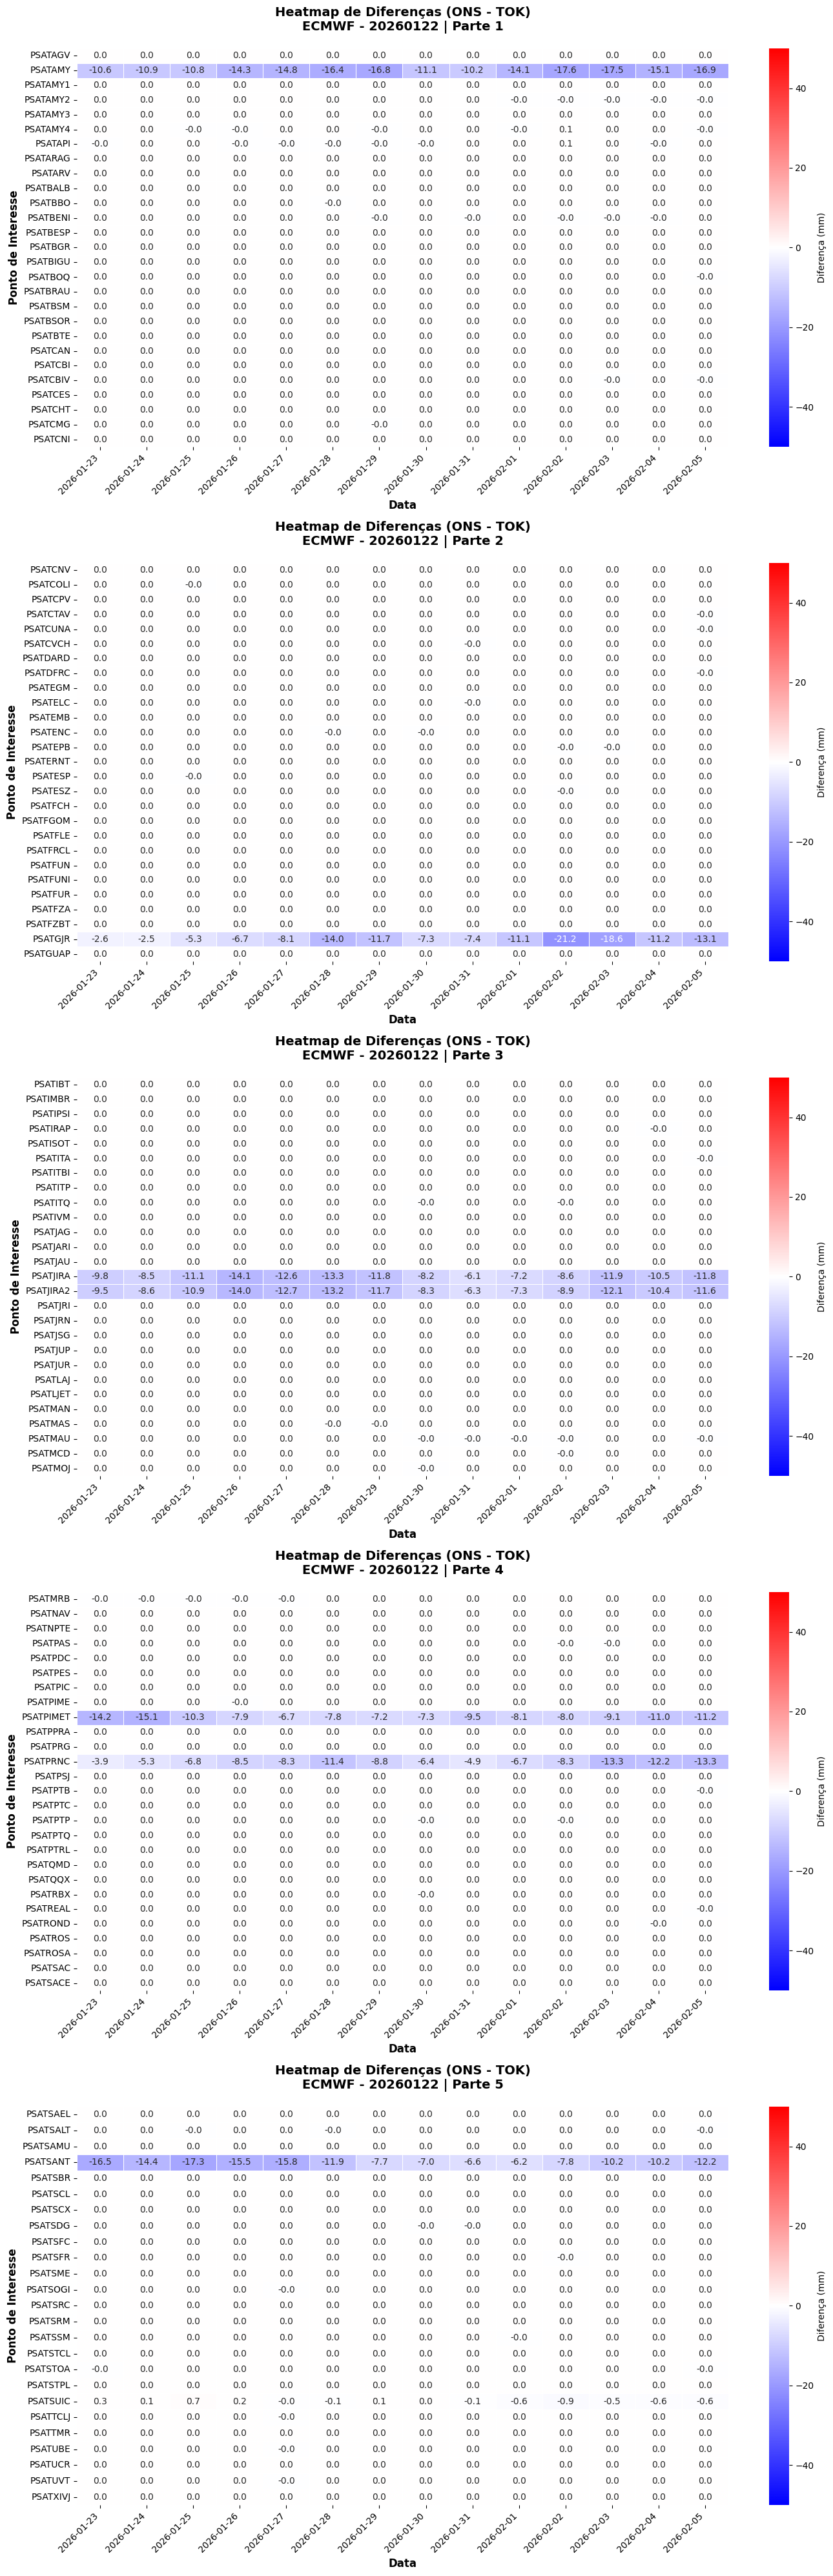

Matriz de diferenças salva em: ECMWF/20260122/Output/matriz_diferencas_20260122.csv


In [44]:
# Garantir datetime mesmo se já estiver string
dados_comparacao['data'] = pd.to_datetime(dados_comparacao['data'], errors='coerce')

dados_comparacao['data'] = dados_comparacao['data'].dt.strftime('%Y-%m-%d')
matriz_diferencas = dados_comparacao.pivot_table(
    index='ponto',
    columns='data',
    values='diferenca',
    aggfunc='mean'
).fillna(0)

# Dividir em blocos de no máximo 27 pontos
max_pontos = 27
pontos = matriz_diferencas.index.tolist()
blocos = [pontos[i:i + max_pontos] for i in range(0, len(pontos), max_pontos)]

# Criar uma única figura com subplots (um por bloco)
n_blocos = len(blocos)
fig, axes = plt.subplots(n_blocos, 1, figsize=(14, 8 * n_blocos), squeeze=False)

for i, bloco in enumerate(blocos, start=1):
    matriz_bloco = matriz_diferencas.loc[bloco]
    ax = axes[i - 1, 0]

    sns.heatmap(
        matriz_bloco,
        cmap='bwr',
        center=0,
        vmin=-50,
        vmax=50,
        annot=True,
        fmt='.1f',
        linewidths=0.5,
        cbar_kws={'label': 'Diferença (mm)'},
        ax=ax
    )

    ax.set_title(
        f'Heatmap de Diferenças (ONS - TOK)\n{nome_modelo} - {data_rodada} | Parte {i}',
        fontsize=14, fontweight='bold', pad=20
    )
    ax.set_xlabel('Data', fontsize=12, fontweight='bold')
    ax.set_ylabel('Ponto de Interesse', fontsize=12, fontweight='bold')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()

arquivo_heatmap = caminho_output / f"heatmap_diferencas_{data_rodada}.png"
plt.savefig(arquivo_heatmap, dpi=300, bbox_inches='tight')
print(f"\nHeatmap salvo em: {arquivo_heatmap}")

plt.show()

# Salvar matriz de diferenças completa
arquivo_matriz = caminho_output / f"matriz_diferencas_{data_rodada}.csv"
matriz_diferencas.to_csv(arquivo_matriz)
print(f"Matriz de diferenças salva em: {arquivo_matriz}")

## 10. Heatmap de Diferenças Absolutas


Heatmap de diferenças absolutas salvo em: ECMWF/20260122/Output/heatmap_diferencas_absolutas_20260122.png


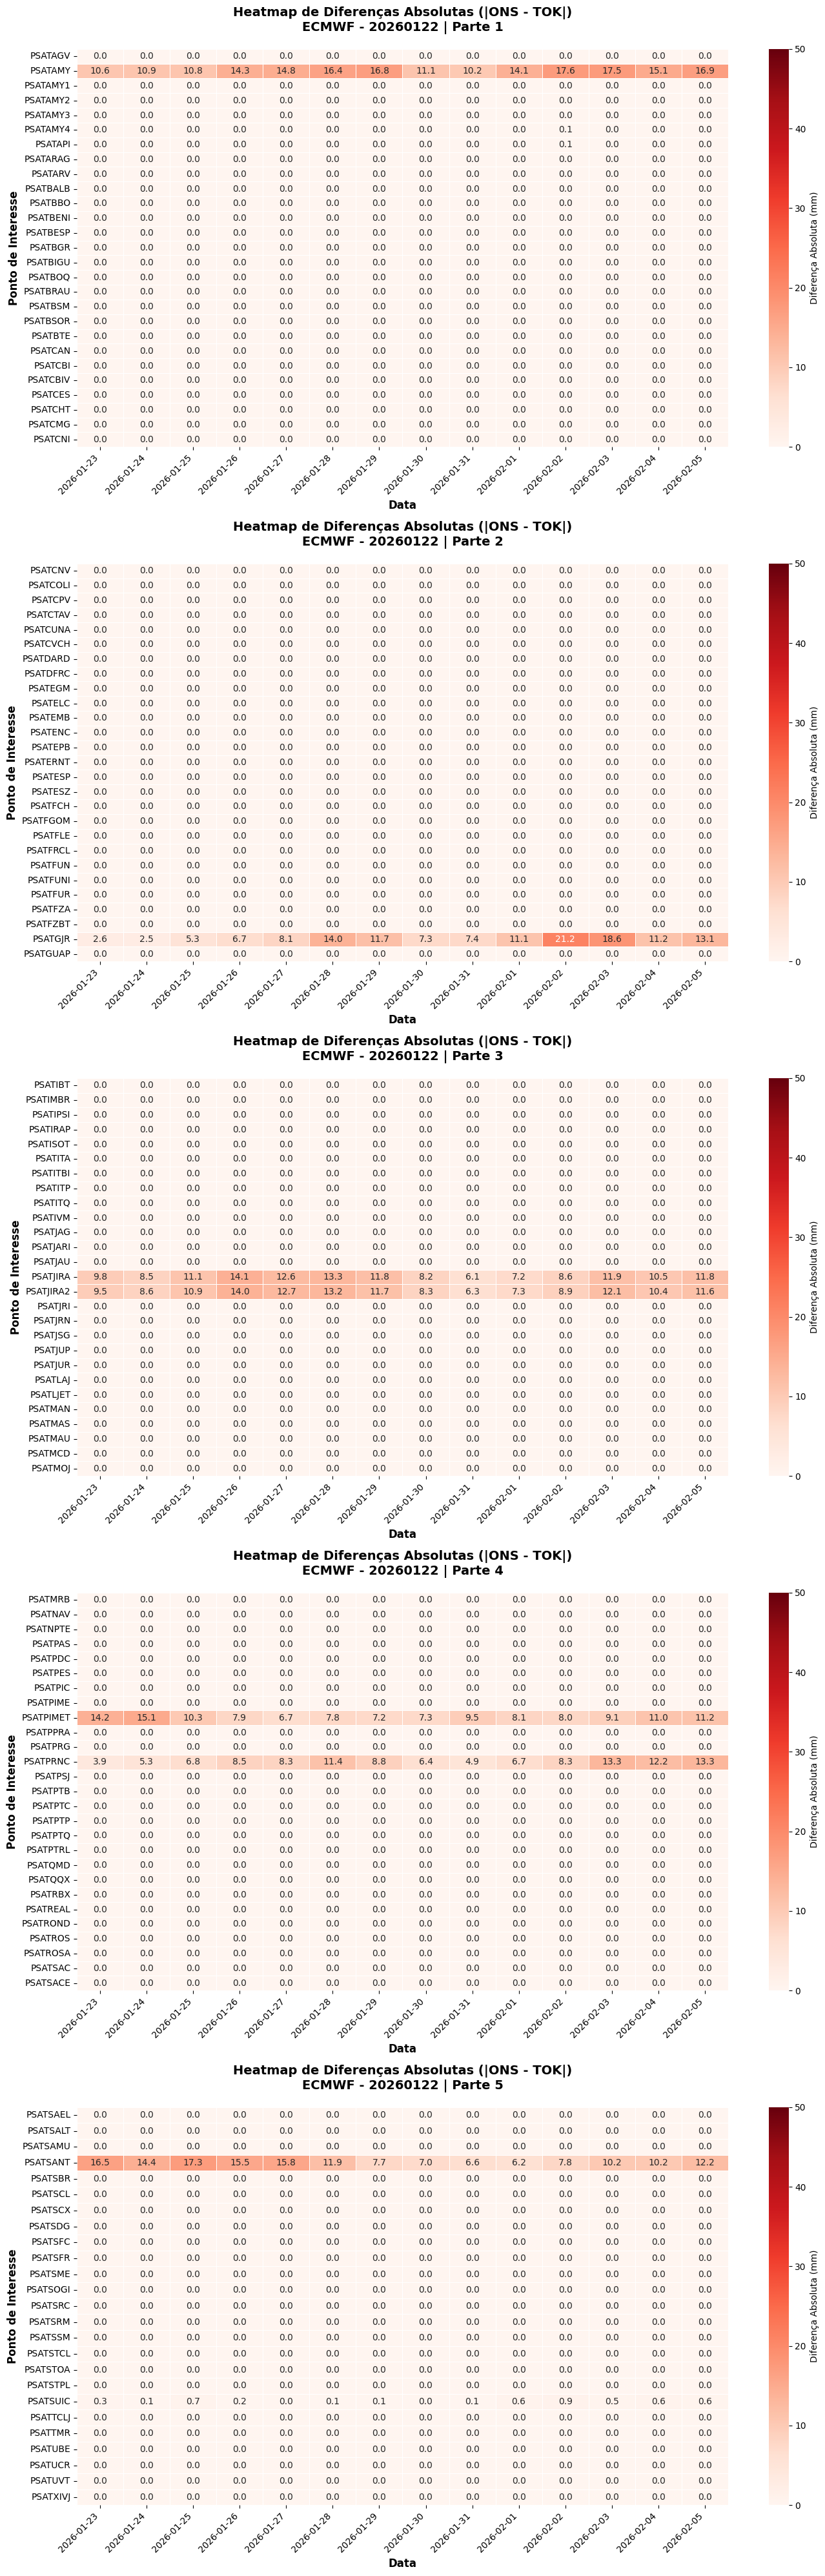

In [45]:

# Criar matriz para heatmap de diferenças absolutas
matriz_dif_abs = dados_comparacao.pivot_table(
    index='ponto',
    columns='data',
    values='diferenca_abs',
    aggfunc='mean'
).fillna(0)

# Dividir em blocos de no máximo 27 pontos
max_pontos = 27
pontos = matriz_dif_abs.index.tolist()
blocos = [pontos[i:i + max_pontos] for i in range(0, len(pontos), max_pontos)]

# Criar uma única figura com subplots (um por bloco)
n_blocos = len(blocos)
fig, axes = plt.subplots(n_blocos, 1, figsize=(14, 8 * n_blocos), squeeze=False)

for i, bloco in enumerate(blocos, start=1):
    matriz_bloco = matriz_dif_abs.loc[bloco]
    ax = axes[i - 1, 0]

    sns.heatmap(
        matriz_bloco,
        cmap='Reds',
        vmin=0,
        vmax=50,
        annot=True,
        fmt='.1f',
        linewidths=0.5,
        cbar_kws={'label': 'Diferença Absoluta (mm)'},
        ax=ax
    )

    ax.set_title(
        f'Heatmap de Diferenças Absolutas (|ONS - TOK|)\n{nome_modelo} - {data_rodada} | Parte {i}',
        fontsize=14, fontweight='bold', pad=20
    )
    ax.set_xlabel('Data', fontsize=12, fontweight='bold')
    ax.set_ylabel('Ponto de Interesse', fontsize=12, fontweight='bold')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()

arquivo_heatmap_abs = caminho_output / f"heatmap_diferencas_absolutas_{data_rodada}.png"
plt.savefig(arquivo_heatmap_abs, dpi=300, bbox_inches='tight')
print(f"\nHeatmap de diferenças absolutas salvo em: {arquivo_heatmap_abs}")

plt.show()


## 11. Visualizações Adicionais


Gráficos de barras salvos em: ECMWF/20260122/Output/graficos_acumulados_20260122.png


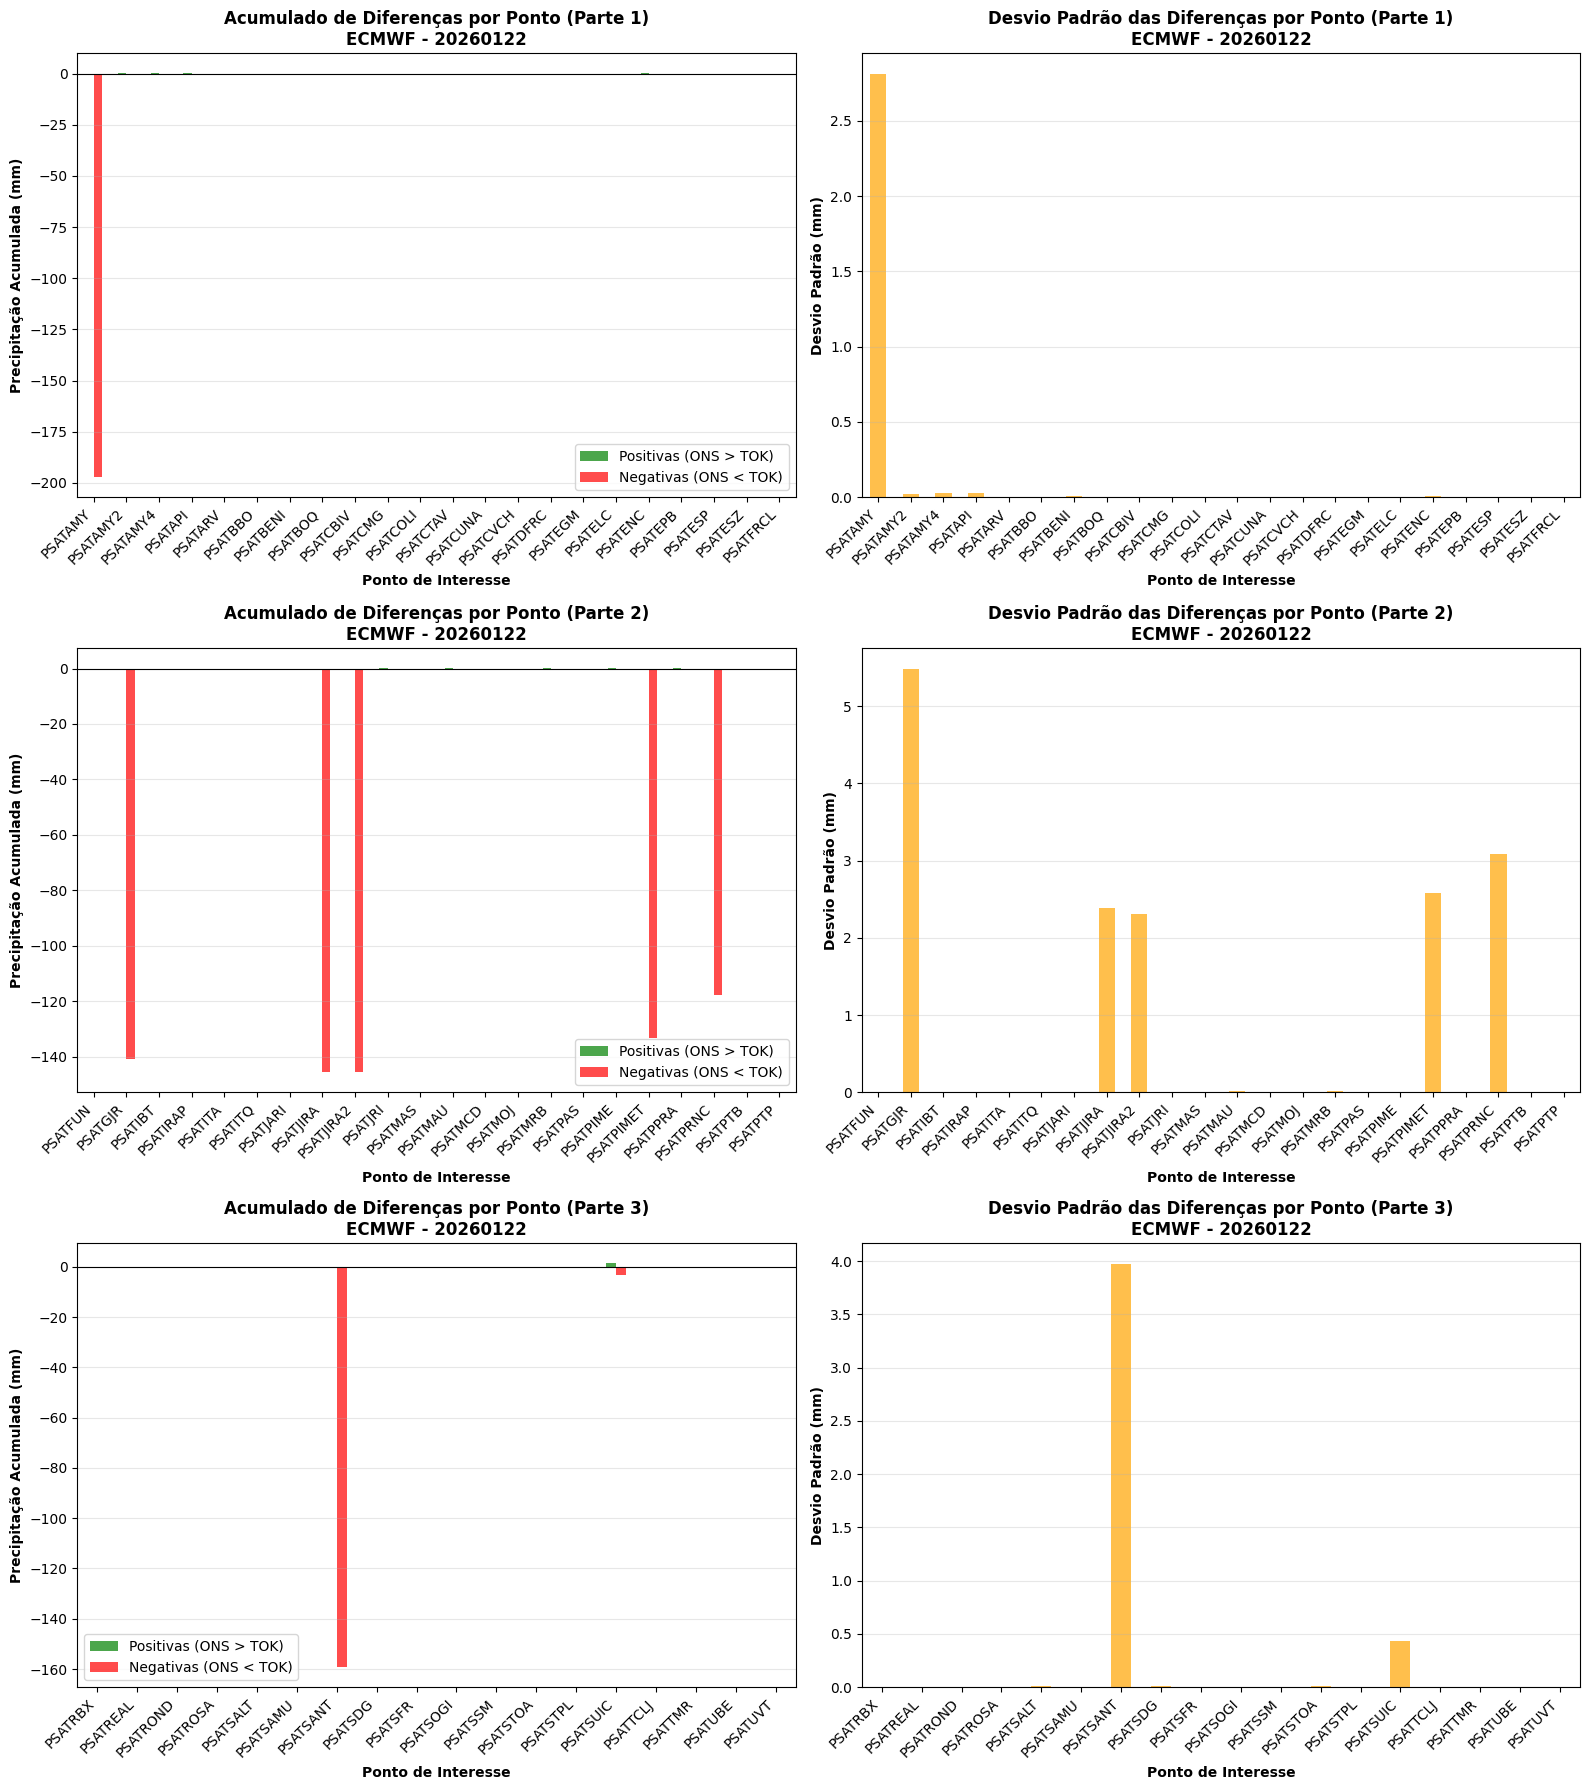

In [46]:
pontos = acumulados.index.tolist()
max_pontos = len(pontos) // 3 + len(pontos) % 3
blocos = [pontos[i:i + max_pontos] for i in range(0, len(pontos), max_pontos)]

n_blocos = len(blocos)
fig, axes = plt.subplots(n_blocos, 2, figsize=(16, 6 * n_blocos), squeeze=False)

for i, bloco in enumerate(blocos, start=1):
    ax1 = axes[i - 1, 0]
    ax2 = axes[i - 1, 1]

    # Gráfico 1: Diferenças positivas e negativas
    acumulados.loc[bloco, ['Acumulado_Positivo_mm', 'Acumulado_Negativo_mm']].plot(
        kind='bar',
        ax=ax1,
        color=['green', 'red'],
        alpha=0.7
    )
    ax1.set_title(f'Acumulado de Diferenças por Ponto (Parte {i})\n{nome_modelo} - {data_rodada}',
                  fontsize=12, fontweight='bold')
    ax1.set_xlabel('Ponto de Interesse', fontsize=10, fontweight='bold')
    ax1.set_ylabel('Precipitação Acumulada (mm)', fontsize=10, fontweight='bold')
    ax1.legend(['Positivas (ONS > TOK)', 'Negativas (ONS < TOK)'])
    ax1.grid(axis='y', alpha=0.3)
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

    # Gráfico 2: Desvio padrão por ponto
    tabela_desvios.loc[bloco].plot(kind='bar', ax=ax2, color='orange', alpha=0.7, legend=False)
    ax2.set_title(f'Desvio Padrão das Diferenças por Ponto (Parte {i})\n{nome_modelo} - {data_rodada}',
                  fontsize=12, fontweight='bold')
    ax2.set_xlabel('Ponto de Interesse', fontsize=10, fontweight='bold')
    ax2.set_ylabel('Desvio Padrão (mm)', fontsize=10, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()

arquivo_barras = caminho_output / f"graficos_acumulados_{data_rodada}.png"
plt.savefig(arquivo_barras, dpi=300, bbox_inches='tight')
print(f"\nGráficos de barras salvos em: {arquivo_barras}")

plt.show()


## 12. Distribuição das Diferenças


Histograma + Boxplots salvos em: ECMWF/20260122/Output/histograma_boxplot_diferencas_20260122.png


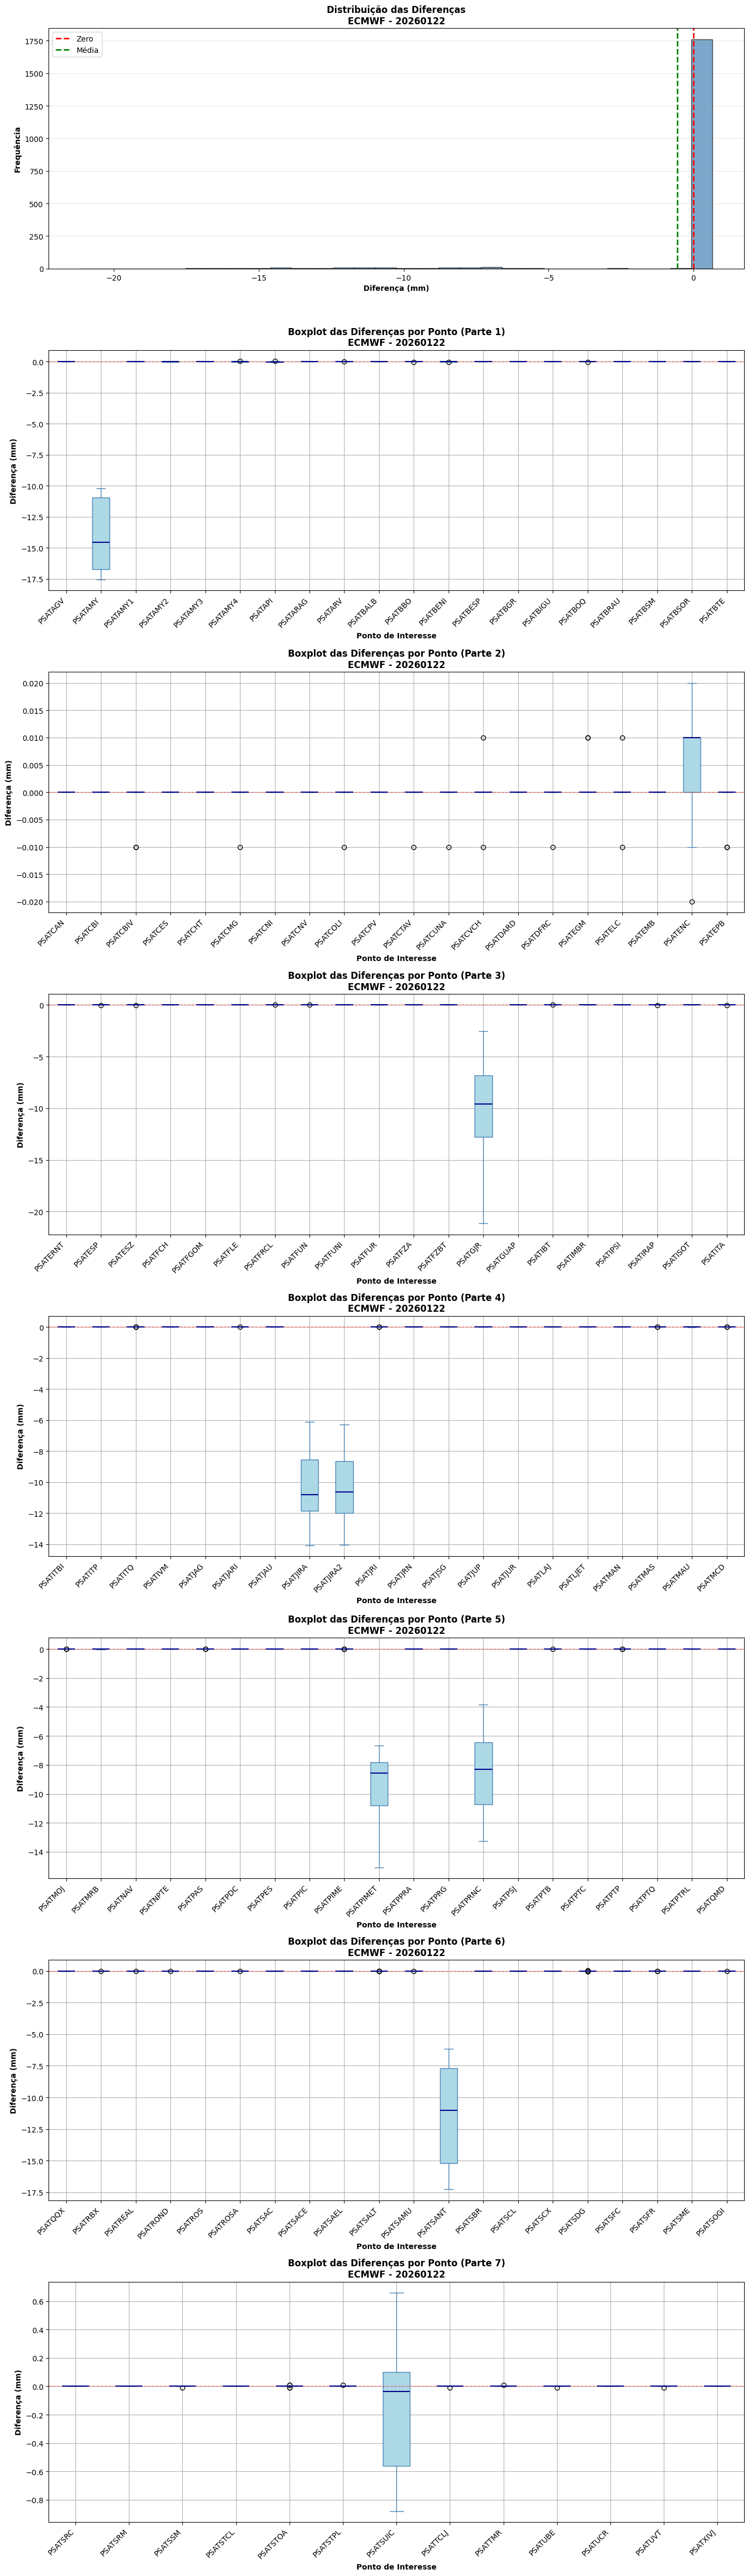

In [47]:
# Histograma e boxplot das diferenças (na mesma figura)
max_pontos = 20
pontos = sorted(dados_comparacao['ponto'].unique())
blocos = [pontos[i:i + max_pontos] for i in range(0, len(pontos), max_pontos)]
n_blocos = len(blocos)

fig, axes = plt.subplots(n_blocos + 1, 1, figsize=(14, 6 * (n_blocos + 1)), squeeze=False)

# Histograma no primeiro quadro
ax_hist = axes[0, 0]
ax_hist.hist(dados_comparacao['diferenca'], bins=30, color='steelblue', alpha=0.7, edgecolor='black')
ax_hist.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero')
ax_hist.axvline(x=dados_comparacao['diferenca'].mean(), color='green', linestyle='--', linewidth=2, label='Média')
ax_hist.set_title(f'Distribuição das Diferenças\n{nome_modelo} - {data_rodada}', fontsize=12, fontweight='bold')
ax_hist.set_xlabel('Diferença (mm)', fontsize=10, fontweight='bold')
ax_hist.set_ylabel('Frequência', fontsize=10, fontweight='bold')
ax_hist.legend()
ax_hist.grid(axis='y', alpha=0.3)

# Boxplots nos quadros seguintes
for i, bloco in enumerate(blocos, start=1):
    ax = axes[i, 0]
    dados_bloco = dados_comparacao[dados_comparacao['ponto'].isin(bloco)]
    dados_bloco.boxplot(
        column='diferenca',
        by='ponto',
        ax=ax,
        patch_artist=True,
        boxprops=dict(facecolor='lightblue', edgecolor='steelblue'),
        medianprops=dict(color='darkblue', linewidth=1.5),
        whiskerprops=dict(color='steelblue'),
        capprops=dict(color='steelblue')
    )

    ax.set_title(f'Boxplot das Diferenças por Ponto (Parte {i})\n{nome_modelo} - {data_rodada}',
                 fontsize=12, fontweight='bold')
    ax.set_xlabel('Ponto de Interesse', fontsize=10, fontweight='bold')
    ax.set_ylabel('Diferença (mm)', fontsize=10, fontweight='bold')
    ax.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.suptitle('')
plt.tight_layout()

arquivo_hist_box = caminho_output / f"histograma_boxplot_diferencas_{data_rodada}.png"
plt.savefig(arquivo_hist_box, dpi=300, bbox_inches='tight')
print(f"\nHistograma + Boxplots salvos em: {arquivo_hist_box}")

plt.show()

## 13. Relatório Consolidado

In [48]:
# Criar relatório consolidado

# Top/Bottom por Dif_total
top_n = 10
dif_total_ordenado = stats_por_ponto['Dif_total'].sort_values(ascending=False)
maiores_diferencas = dif_total_ordenado.head(top_n)
menores_diferencas = dif_total_ordenado.tail(top_n).sort_values()

lista_maiores = "\n".join([f"  - {idx}: {val:.2f} mm" for idx, val in maiores_diferencas.items()])
lista_menores = "\n".join([f"  - {idx}: {val:.2f} mm" for idx, val in menores_diferencas.items()])

# Top/Bottom por diferenças acumuladas (Total_Liquido_mm)
acum_ordenado = acumulados['Total_Liquido_mm'].sort_values(ascending=False)
maiores_acumuladas = acum_ordenado.head(top_n)
menores_acumuladas = acum_ordenado.tail(top_n).sort_values()

lista_maiores_acum = "\n".join([f"  - {idx}: {val:.2f} mm" for idx, val in maiores_acumuladas.items()])
lista_menores_acum = "\n".join([f"  - {idx}: {val:.2f} mm" for idx, val in menores_acumuladas.items()])

relatorio = f"""
{'='*80}
RELATÓRIO DE COMPARAÇÃO DE PRECIPITAÇÃO - ONS vs TOK
{'='*80}
Modelo: {nome_modelo}
Horizonte: {horizonte}
Data da Rodada: {data_rodada}

{'='*80}
ESTATÍSTICAS GERAIS
{'='*80}

Total de registros comparados: {dados_comparacao.shape[0]}
Número de pontos de interesse: {dados_comparacao['ponto'].nunique()}
Período analisado: {dados_comparacao['data'].min()} a {dados_comparacao['data'].max()}

Precipitação Total ONS: {dados_comparacao['precipitacao_mm_ons'].sum():.2f} mm
Precipitação Total TOK: {dados_comparacao['precipitacao_mm_tok'].sum():.2f} mm

{'='*80}
ANÁLISE DAS DIFERENÇAS
{'='*80}

Diferença Média: {dados_comparacao['diferenca'].mean():.2f} mm
Desvio Padrão das Diferenças: {dados_comparacao['diferenca'].std():.2f} mm
Diferença Mínima: {dados_comparacao['diferenca'].min():.2f} mm
Diferença Máxima: {dados_comparacao['diferenca'].max():.2f} mm

Acumulado de Diferenças Positivas: {acumulado_positivo.sum():.2f} mm
Acumulado de Diferenças Negativas: {acumulado_negativo.sum():.2f} mm
Diferença Líquida Total: {acumulados['Total_Liquido_mm'].sum():.2f} mm

Percentual de registros com ONS > TOK: {(dados_comparacao['diferenca'] > 0).sum() / len(dados_comparacao) * 100:.1f}%
Percentual de registros com ONS < TOK: {(dados_comparacao['diferenca'] < 0).sum() / len(dados_comparacao) * 100:.1f}%
Percentual de registros com ONS = TOK: {(dados_comparacao['diferenca'] == 0).sum() / len(dados_comparacao) * 100:.1f}%

{'='*80}
PONTOS COM MAIORES E MENORES DIFERENÇAS (Dif_total)
{'='*80}

Maiores diferenças (top {top_n}):
{lista_maiores}

Menores diferenças (bottom {top_n}):
{lista_menores}

Máximo entre pontos: {dif_total_ordenado.max():.2f} mm
Mínimo entre pontos: {dif_total_ordenado.min():.2f} mm

{'='*80}
PONTOS COM MAIORES E MENORES DIFERENÇAS ACUMULADAS (Total_Liquido_mm)
{'='*80}

Maiores acumuladas (top {top_n}):
{lista_maiores_acum}

Menores acumuladas (bottom {top_n}):
{lista_menores_acum}

Máximo entre pontos: {acum_ordenado.max():.2f} mm
Mínimo entre pontos: {acum_ordenado.min():.2f} mm
...
"""

print(relatorio)

print(relatorio)

# Salvar relatório
arquivo_relatorio = caminho_output / f"relatorio_consolidado_{nome_modelo}_{data_rodada}.txt"
with open(arquivo_relatorio, 'w', encoding='utf-8') as f:
    f.write(relatorio)

print(f"\nRelatório consolidado salvo em: {arquivo_relatorio}")


RELATÓRIO DE COMPARAÇÃO DE PRECIPITAÇÃO - ONS vs TOK
Modelo: ECMWF
Horizonte: 15
Data da Rodada: 20260122

ESTATÍSTICAS GERAIS

Total de registros comparados: 1862
Número de pontos de interesse: 133
Período analisado: 2026-01-23 a 2026-02-05

Precipitação Total ONS: 15429.83 mm
Precipitação Total TOK: 16470.94 mm

ANÁLISE DAS DIFERENÇAS

Diferença Média: -0.56 mm
Desvio Padrão das Diferenças: 2.51 mm
Diferença Mínima: -21.16 mm
Diferença Máxima: 0.66 mm

Acumulado de Diferenças Positivas: 2.44 mm
Acumulado de Diferenças Negativas: -1043.55 mm
Diferença Líquida Total: -1.88 mm

Percentual de registros com ONS > TOK: 4.0%
Percentual de registros com ONS < TOK: 9.9%
Percentual de registros com ONS = TOK: 86.0%

PONTOS COM MAIORES E MENORES DIFERENÇAS (Dif_total)

Maiores diferenças (top 10):
  - PSATENC: 0.08 mm
  - PSATAMY4: 0.06 mm
  - PSATPPRA: 0.05 mm
  - PSATSDG: 0.04 mm
  - PSATJRI: 0.02 mm
  - PSATEGM: 0.02 mm
  - PSATMRB: 0.02 mm
  - PSATAPI: 0.02 mm
  - PSATPIME: 0.01 mm
  - PSA

## 14. Resumo Final

Este notebook realizou a comparação completa entre os dados de precipitação das fontes ONS e TOK.

### Principais Outputs:

1. **Tabelas com Heatmaps**: Visualizações das diferenças por ponto de interesse e data
2. **Acumulados**: Diferenças positivas e negativas acumuladas por ponto
3. **Desvio Padrão**: Análise da variabilidade das diferenças
4. **Relatório Consolidado**: Documento com todas as estatísticas principais

### Próximos Passos:

- Ajuste os parâmetros na seção 1 conforme necessário
- Adapte as funções de carregamento de dados se o formato dos seus arquivos for diferente
- Execute todas as células para gerar uma nova análise
- Os outputs serão organizados no diretório de saída conforme a estrutura de input